In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import lecture02

names = open("names.txt").read().split()
names = names

chars = sorted(set("".join(names)))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)
print(itos)
vocab_size

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


27

In [9]:

block_size = 3

def build_dataset(words):
    X, Y = [], []

    for word in words:
        context = [0] * block_size
        for ch in word + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

print(Xtr.size())
print(Xdev.size())
print(Xte.size())


torch.Size([182580, 3])
torch.Size([22767, 3])
torch.Size([22799, 3])


In [10]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, 20),generator=g)
W1 = torch.randn((60,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

test=True
if test:
    for p in parameters:
        p.fill_(0.1)
for p in parameters:
    p.requires_grad = True


In [12]:
lri = []
lossi = []
stepi = []

for i in range(20):
    ix = torch.randint(0, Xtr.shape[0], (1,))

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 60) @ W1+b1)
    logits = (h @ W2 + b2)
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())
    print(f"{i}")
print(loss.item())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
7.8671345710754395


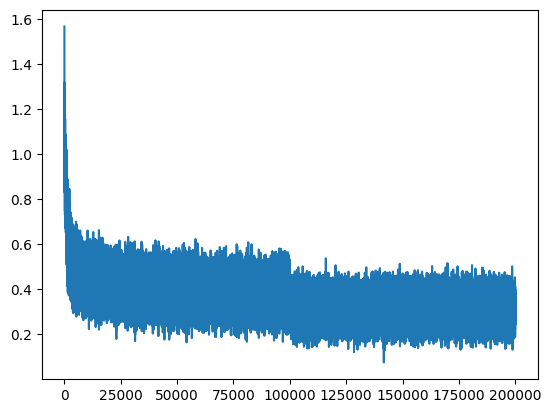

In [127]:
plt.plot(stepi, lossi)

In [129]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 80) @ W1 + b1)
logits = (h@W2+b2)
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.1055846214294434

In [130]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 80) @ W1 + b1)
logits = (h@W2+b2)
loss = F.cross_entropy(logits, Ydev)
loss


tensor(2.1853, grad_fn=<NllLossBackward0>)

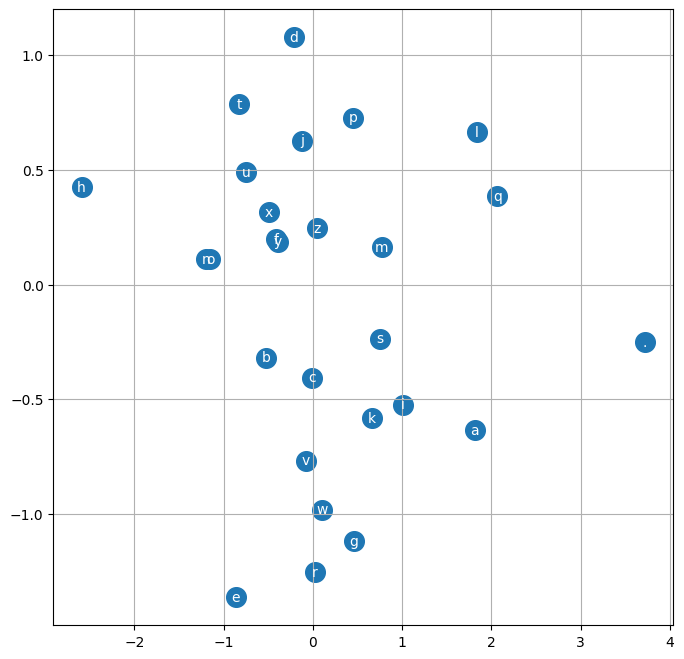

In [121]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [24]:
print(C.shape)
print(vocab_size)
print(len(itos.keys()))
C

torch.Size([27, 2])
27
27


tensor([[-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.],
        [-0., -0.]], requires_grad=True)

In [37]:
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
